In [20]:
import numpy as np
import sympy as smp
from sympy import *
import matplotlib.pyplot as plt
import scienceplots
from astropy.io import ascii
import os
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy.integrate import trapz
import math
from IPython.display import clear_output
from collections import Counter

In [2]:
def templatefit(template, Fnu_obs, lam_obs, errors, z_spec, npoints):
    # ---------
    # Input SED
    # ---------
    sed = ascii.read(template)
    # -----------
    # ADOPTED SED
    # -----------
    lam_tab = sed['col1']  * 10.0**(-4.0)   # microns
    Llam_tab = sed['col2']  # erg/s/Angstrom
    nu_tab = 3.0*10.0**8.0/(lam_tab*10.0**(-6.0))   # Hz
    Lnu_tab = Llam_tab/nu_tab**2.0    # erg/s/Hz but with arbitrary normalization
    #--------------
    # Observed data values
    #--------------
    z_shifted_lam = lam_tab*(1+z_spec)
    error_z = 0.0007
    
    # Interpolating the Luminosity for required wavelengths
    Fnu_obs_for_scaling = []
    l_for_scaling = []
    errors_for_scaling = []
    for i in range(len(Fnu_obs)):
        if i < npoints:
            Fnu_obs_for_scaling.append(Fnu_obs[i])#reducing the number of data points at RJ limit due to variations in beta
            l_for_scaling.append(np.interp(lam_obs[i], z_shifted_lam, Lnu_tab))
            errors_for_scaling.append(errors[i])
    Fnu_obs_for_scaling = np.array(Fnu_obs_for_scaling)
    errors_for_scaling = np.array(errors_for_scaling)
    l_for_scaling = np.array(l_for_scaling)
    #print(len(l_for_scaling))
    #print(l_for_scaling)
    #--------
    # Determining the scaling constant by minimising chisq
    K = np.sum(Fnu_obs_for_scaling*l_for_scaling/(errors_for_scaling**2))/np.sum((l_for_scaling**2)/(errors_for_scaling**2))
    #K = smp.symbols('K')
    chisq = np.sum(((Fnu_obs_for_scaling - (K * l_for_scaling)) / errors_for_scaling)**2)
    #chisq = np.sum(chisq_terms)
    # Differentiate the chisq with respect to K
    #dchisq_dK = smp.diff(chisq, K)
    # Solve for K by setting the derivative to zero (minimizing chisq)
    #scaling = smp.solve(dchisq_dK, K)[0]
    scaling = K
    #print("the obtained chisquare is",chisq)
    Red_chi_sq = chisq/len(l_for_scaling)
    #print("Reduced Chisq is ",np.sum(((Fnu_obs - scaling*l_for_scaling)/errors)**2)/len(Fnu_obs))
    return scaling ,chisq, z_shifted_lam, Lnu_tab, l_for_scaling, nu_tab, lam_tab

In [3]:
def cdf(sorted_array,xlab,lab):
    n, bins, patches = plt.hist(sorted_array, 50, density=True, histtype='step',cumulative=True, label=lab)
    plt.legend()
    plt.xlabel(xlab)
    #median calculations:
    median_index = (np.abs(n - 0.5)).argmin()
    print(median_index)
    median_value = (bins[median_index] + bins[median_index + 1]) / 2
    confidence_level = 0.95  # Change this to the desired confidence level (e.g., 0.95 for 95% confidence interval)
    plt.axvline(median_value,c='red',label='median')
    plt.legend()
    
    lower_bound = (1 - confidence_level) / 2
    upper_bound = 1 - lower_bound

    lower_index = (np.abs(n - lower_bound)).argmin()
    upper_index = (np.abs(n - upper_bound)).argmin()
    #confidence_bounds_calculations
    lower_confidence_value = (bins[lower_index] + bins[lower_index + 1]) / 2
    upper_confidence_value = (bins[upper_index] + bins[upper_index + 1]) / 2
    #error Calculations:
    lower_err = median_value-lower_confidence_value
    upper_err = upper_confidence_value - median_value
    err = [[lower_err],[upper_err]]
    return median_value, err

In [4]:
fileslist = []
directory = os.fsencode('/home/ruthvik/Jupyter-notebooks/lensingproject/Berta+13 SED TEMPLATES/')
    
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".norm_LIR"): 
        fileslist.append((os.path.join('/home/ruthvik/Jupyter-notebooks/lensingproject/Berta+13 SED TEMPLATES/', filename)))
        continue

In [5]:
z_spec = 4.225# reuter et al/weiss et al
Fnu_obs = np.array([1.73244184e-3,3.8381915e-3,2.8184781e-3,3.022749e-3,7.14077176e-3,13.41180447e-3,35.59236792e-3,74.6496116e-3,114.72180071e-3,101.54047281e-3,85.89271085e-3,103.84769362e-3,101.39115397e-3,115,189,187,100,33.5,7.2,0.79])#only includes fluxes and wavelengths from the weiss paper. (mJy)
lam_obs = np.array([1.15,1.50,2.00,2.77,3.56,4.44,5.60,7.70,10.00,12.80,15.00,18.00,22.00,250,350,500,870,1.4*10**3,2.0*10**3,3*10**3])#observed wavelengths (microns)
errors = [0.0570548e-3,0.08028915e-3,0.06155723e-3,0.06236562e-3,0.07528398e-3,0.06820367e-3,0.39331983e-3,0.52093167e-3,0.90008395e-3,1.14382428e-3,1.24125703e-3,1.4759518e-3,1.35577749e-3,14,20,20,20,6.4,1.5,0.13]#for error bars
Fnu_obs = np.array(Fnu_obs)*10**(-26)
errors = np.array(errors)*10**(-26)
for i in range(len(errors)):
    if errors[i] < (20/100)*(Fnu_obs[i]):
        errors[i] = (20/100)*(Fnu_obs[i])
number_of_iterations = 1000
points_to_fit = 15
f = np.zeros([len(Fnu_obs),number_of_iterations])
for i in range(len(Fnu_obs)):
    f[i] = np.random.normal(Fnu_obs[i],errors[i],number_of_iterations)
f = np.transpose(f)
magnification_factor = 32.3
sig_mu = 2.5
mags = np.random.normal(magnification_factor, sig_mu, number_of_iterations)

In [6]:
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)
D_L = cosmo.luminosity_distance(z_spec).value# Luminosity distance to the galaxy
D_L = D_L*3.0857*10**24 #conversion to centimeters
shifting_constant = (1+z_spec)/(4*np.pi*(D_L**2))#to bring the SED back to the rest frame
shifting_constant

2.9857866064221533e-59

In [7]:
scaling_consts = np.zeros([len(f),len(fileslist)])
chi_sq_list = np.zeros([len(f),len(fileslist)])
redshifted_lam = np.zeros([len(f),len(fileslist),11005])
Lum_nu_tab = np.zeros([len(f),len(fileslist),11005])
nu_restframe = np.zeros([len(f),len(fileslist),11005])
lambda_restframe = np.zeros([len(f),len(fileslist),11005])
L_scaling = np.zeros([len(f),len(fileslist),points_to_fit])
best_chi_sq_list = np.zeros(number_of_iterations)
best_K_list = np.zeros(number_of_iterations)
obs_infra_red_luminosity_erg_per_sec = np.zeros(number_of_iterations)
obs_LH = np.zeros(number_of_iterations)
best_fit_template_list = []
for i in range(number_of_iterations):
    print("realisation: ", i+1)
    for j in range(len(fileslist)):
        scaling_consts[i][j], chi_sq_list[i][j], redshifted_lam[i][j], Lum_nu_tab[i][j], L_scaling[i][j], nu_restframe[i][j], lambda_restframe[i][j] = templatefit(fileslist[j],f[i], lam_obs, errors, z_spec, points_to_fit)    
    #minimum chi_sq estimation and obtaining the infra-red and H-band frequencies
    chi_sq = np.min(chi_sq_list[i])
    best_chi_sq_list[i] = chi_sq
    loc = np.where(chi_sq_list[i] == chi_sq)
    loc = loc[0][0]
    best_fit_template_list.append(fileslist[loc])
    best_K_list[i] = scaling_consts[i][loc]
    restframe_normalisation_constant = scaling_consts[i][loc]/shifting_constant
    infrared_frequency = []
    H_band_frequency = []
    rest_frame_luminosities_for_LIR_without_normalisation = []
    rest_frame_luminosities_for_H_band_without_normalisation = []
    for l in range(len(lambda_restframe[i][loc])):
        if (lambda_restframe[i][loc][l] >= 3) & (lambda_restframe[i][loc][l] <= 1100):
            infrared_frequency.append(nu_restframe[i][loc][l])
            rest_frame_luminosities_for_LIR_without_normalisation.append(Lum_nu_tab[i][loc][l])
        if (lambda_restframe[i][loc][l] >= 1.3) & (lambda_restframe[i][loc][l] <= 1.9):
            H_band_frequency.append(nu_restframe[i][loc][l])
            rest_frame_luminosities_for_H_band_without_normalisation.append(Lum_nu_tab[i][loc][l])
    #infrared:
    infrared_frequency = np.array(infrared_frequency)
    #rest frame monochromatic infrared luminosities in erg/s:
    rest_frame_monocrom_luminosities_for_LIR = np.array(rest_frame_luminosities_for_LIR_without_normalisation)*restframe_normalisation_constant
    #rest frame LIR calculations:
    infra_red_luminosity = trapz(y = rest_frame_monocrom_luminosities_for_LIR , x = infrared_frequency)
    obs_infra_red_luminosity_erg_per_sec[i] = infra_red_luminosity 
    #H band:
    H_band_frequency = np.array(H_band_frequency)
    #rest frame monochromatic H band luminosities in ergs/s:
    rest_frame_H_band_Lum = np.array(rest_frame_luminosities_for_H_band_without_normalisation)*restframe_normalisation_constant#normalising the luminosity
    #rest frame H band luminosity calculations:
    H_band_lum = trapz(y = rest_frame_H_band_Lum, x = H_band_frequency)# in Watts 
    obs_LH[i] = H_band_lum/(3.828*10**33)#conversion to L_sun
    clear_output()

In [8]:
obs_infra_red_luminosity_erg_per_sec = np.abs(obs_infra_red_luminosity_erg_per_sec)
obs_LH = np.abs(obs_LH)

In [9]:
#SFR calculations:
log_Cx = 43.41
lir_dispersion = 0.2 #(assumed) in dex (ref - Jeyhan S. Kartaltepe)
lh_to_sm_conv_fac = 3.8 #ref(wardlow)
lh_dispersion = 0.3 #dex
H_band_lum_accounting_for_dispersion = np.zeros(number_of_iterations)
infra_red_lum_accounting_for_dispersion = np.zeros(number_of_iterations)
#print(obs_infra_red_luminosity_erg_per_sec)
#print(np.log10(obs_infra_red_luminosity_erg_per_sec[0]))
for m in range(number_of_iterations):
    infra_red_lum_accounting_for_dispersion[m] = np.random.normal(math.log10(obs_infra_red_luminosity_erg_per_sec[m]),lir_dispersion,1)
    H_band_lum_accounting_for_dispersion[m] = np.random.normal(np.log10(obs_LH[m]),lh_dispersion,1)
#SFR calculations:
log_SFR = (infra_red_lum_accounting_for_dispersion-log_Cx)
SFR = 10**(log_SFR)
SFR_corrected_for_mag = SFR/mags
SFR_corrected_for_mag = np.log10(SFR_corrected_for_mag)
SFR_corrected_for_mag.sort()
#Stellar Mass calculations:
log_sm = H_band_lum_accounting_for_dispersion - np.log10(lh_to_sm_conv_fac)
sm = 10**(log_sm)
sm_corrected_for_mag = sm/mags
sm_corrected_for_mag = np.log10(sm_corrected_for_mag/1.5)#to account for the correct IMF (chabrier)
sm_corrected_for_mag.sort()

*2 way: plot a CDF, median is the best estimate and error with 68% confidence region 
mention that we have used 68% or 97% depending on your choice... 

*PLot other galaxies on the GMS from other literatures(Mattia's for example...)


23


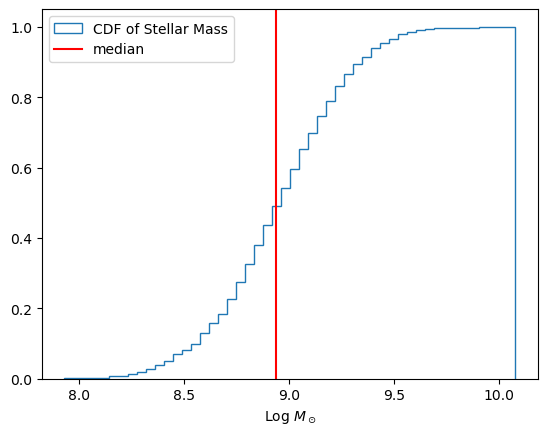

In [10]:
sm_median, sm_error = cdf(sm_corrected_for_mag, r'Log $M_\odot$',"CDF of Stellar Mass")

23


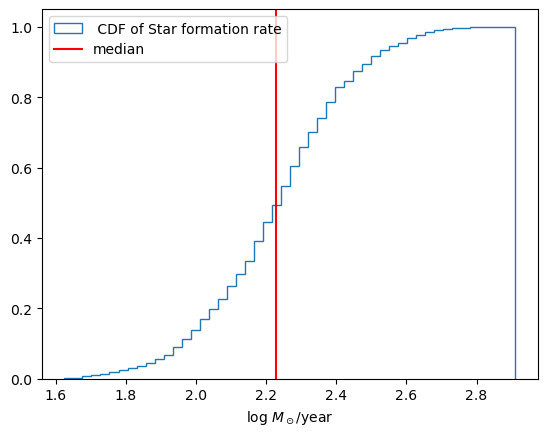

In [11]:
SFR_median, SFR_error = cdf(SFR_corrected_for_mag, r'log $M_\odot$/year'," CDF of Star formation rate")

CIGALE results MC sampling for magnification correction

In [12]:
cig_sfr = 11261.27
cig_sfr_err = 738.07
cig_sfrs = np.random.normal(cig_sfr, cig_sfr_err, number_of_iterations)
cig_sfrs_mag_corrected = cig_sfrs/mags
log_cig_sfrs_mag_corrected = np.log10(cig_sfrs_mag_corrected)
log_cig_sfrs_mag_corrected.sort()

In [13]:
cig_m = 1447441870237.12
cig_m_err = cig_m*(30/100)
cig_ms = np.random.normal(cig_m, cig_m_err, number_of_iterations)
cig_ms_mag_corrected = cig_ms/mags
log_cig_ms_mag_corrected = np.log10(cig_ms_mag_corrected)
log_cig_ms_mag_corrected.sort()

40


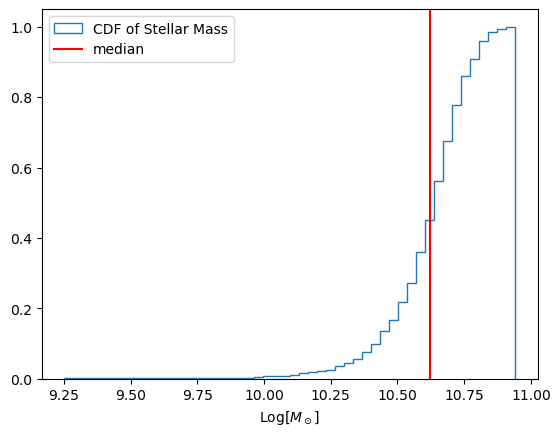

In [14]:
cig_sm_median, cig_sm_error = cdf(log_cig_ms_mag_corrected, r'Log[$M_\odot$]',"CDF of Stellar Mass")

21


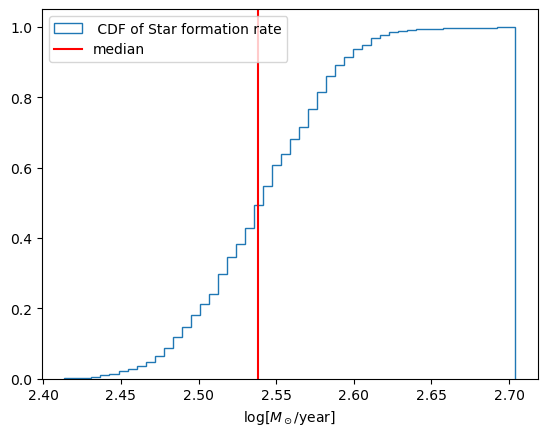

In [15]:
cig_SFR_median, cig_SFR_error = cdf(log_cig_sfrs_mag_corrected, r'log[$M_\odot$/year]'," CDF of Star formation rate")

**SFMS**

In [16]:
t = cosmo.age(z_spec).value
t

1.4166796451213441

In [17]:
log_Ms = np.linspace(8.3,11.1,1000)
log_SFRms = (0.80 - 0.022*(t))*log_Ms - (6.09 - 0.07*(t))
max_log_SFRms = (0.82 - 0.025*t)*log_Ms - (5.86 - 0.04 * t)
min_log_SFRms = (0.78 - 0.019 *t)*log_Ms - (6.32 - 0.1 * t)

(8.3, 11.1)

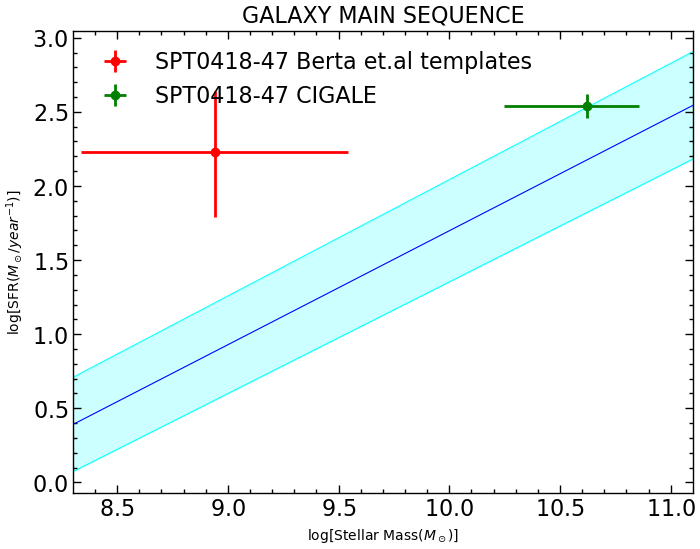

In [18]:
plt.style.use(['science', 'notebook'])
plt.plot(log_Ms,log_SFRms,lw = 0.8,c='blue')
plt.plot(log_Ms,max_log_SFRms, lw = 0.7,c='cyan')
plt.plot(log_Ms,min_log_SFRms,lw = 0.7 ,c='cyan')
plt.errorbar(y = SFR_median, x = sm_median,yerr = SFR_error, xerr = sm_error,fmt ='o',color='red', label = 'SPT0418-47 Berta et.al templates')
plt.errorbar(y = cig_SFR_median, x = cig_sm_median,yerr = cig_SFR_error, xerr = cig_sm_error,fmt ='o',color='green', label = 'SPT0418-47 CIGALE')
plt.fill_between(log_Ms,max_log_SFRms,min_log_SFRms,color = 'cyan' , alpha = 0.2)
plt.legend()
plt.xlabel("log[Stellar Mass($M_\odot$)]")
plt.ylabel("log[SFR(${M_\odot}/year^{-1}$)]")
plt.title("GALAXY MAIN SEQUENCE")
plt.xlim(8.3,11.1)

In [21]:
counter = Counter(best_fit_template_list)
unique_values = list(counter.keys())
occurrences = list(counter.values())

print(f"Unique values: {unique_values}")
print(f"Occurrences: {occurrences}")

Unique values: ['/home/ruthvik/Jupyter-notebooks/lensingproject/Berta+13 SED TEMPLATES/SF_Type1_AGN_4.norm_LIR']
Occurrences: [1000]


In [23]:
np.mean(best_K_list)

11925554.44275965

Text(0, 0.5, 'Flux Density ($F_{\\nu}$) (mJy)')

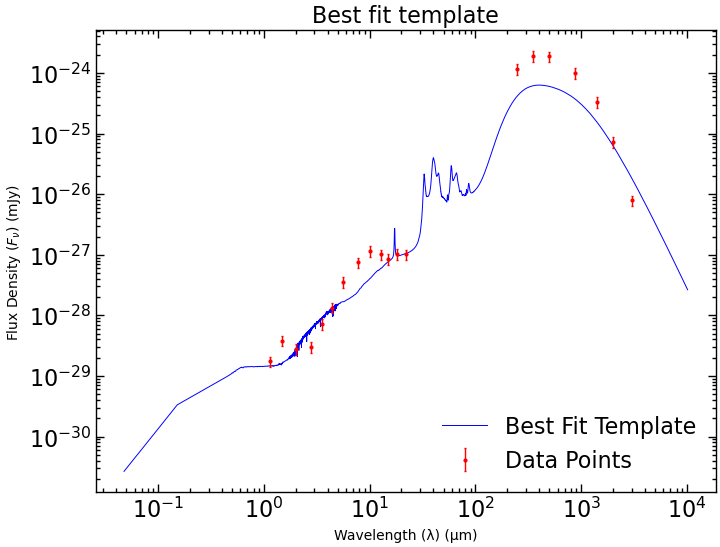

In [25]:
plt.loglog(redshifted_lam[i][loc], Lum_nu_tab[i][loc]*(np.mean(best_K_list)), c ='b', label='Best Fit Template' , linewidth = 0.7)
plt.errorbar(lam_obs, Fnu_obs , yerr = errors,fmt = 'o',ms=2,capsize=1, elinewidth=1, c ='r',label='Data Points')
plt.title("Best fit template")
plt.legend(loc = 'lower right')
plt.xlabel('Wavelength (\u03BB) (\u03BCm)')
plt.ylabel(r'Flux Density ($F_{\nu}$) (mJy)')